# Spanish ULMFiT from scratch

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai import *
from fastai.text import *

In [2]:
# bs=48
# bs=24 
bs = 96
# bs=128

In [3]:
from fastai.utils import *
show_install()



```text
=== Software === 
python        : 3.7.3
fastai        : 1.0.57
fastprogress  : 0.1.21
torch         : 1.2.0
nvidia driver : 430.26
torch cuda    : 9.2.148 / is available
torch cudnn   : 7602 / is enabled

=== Hardware === 
nvidia gpus   : 1
torch devices : 1
  - gpu0      : 11016MB | GeForce RTX 2080 Ti

=== Environment === 
platform      : Linux-4.15.0-60-generic-x86_64-with-debian-buster-sid
distro        : #67-Ubuntu SMP Thu Aug 22 16:55:30 UTC 2019
conda env     : fastai
python        : /home/dpalominop/anaconda3/envs/fastai/bin/python
sys.path      : /home/dpalominop/Projects/course-nlp
/home/dpalominop/anaconda3/envs/fastai/lib/python37.zip
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/lib-dynload

/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages
/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/IPython/extensions
/home/dpalominop/.ipython
```

Please make sure to include open

In [4]:
torch.cuda.set_device(0)

In [5]:
data_path = Config.data_path()

This will create a `viwiki` folder, containing a `viwiki` text file with the wikipedia contents. (For other languages, replace `vi` with the appropriate code from the [list of wikipedias](https://meta.wikimedia.org/wiki/List_of_Wikipedias).)

In [6]:
lang = 'es'
# lang = 'zh'

In [7]:
name = f'{lang}wiki'
path = data_path/name
path.mkdir(exist_ok=True, parents=True)
lm_fns = [f'{lang}_wt', f'{lang}_wt_vocab']

## Spanish wikipedia model

### Download data

In [8]:
from nlputils import split_wiki,get_wiki

In [9]:
# get_wiki(path,lang)

In [9]:
path.ls()

[PosixPath('/home/dpalominop/.fastai/data/eswiki/eswiki'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/docs'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/log'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/wikiextractor'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/eswiki-latest-pages-articles.xml'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/models'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/eswiki-latest-pages-articles.xml.bz2')]

In [10]:
!head -n4 {path}/{name}

<doc id="7" url="https://es.wikipedia.org/wiki?curid=7" title="Andorra">
Andorra

Andorra, oficialmente Principado de Andorra (), es un microestado soberano del suroeste de Europa. Constituido en Estado independiente, de derecho, democrático y social, cuya forma de gobierno es el coprincipado parlamentario. Su territorio está organizado en siete parroquias, con una población total de 78 282 habitantes. Su capital es Andorra la Vieja. 


This function splits the single wikipedia file into a separate file per article. This is often easier to work with.

In [11]:
dest = split_wiki(path,lang)

/home/dpalominop/.fastai/data/eswiki/docs already exists; not splitting


In [12]:
dest.ls()[:5]

[PosixPath('/home/dpalominop/.fastai/data/eswiki/docs/John Felton.txt'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/docs/Nathaniel Bacon.txt'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/docs/Fort Worth.txt'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/docs/Blend S.txt'),
 PosixPath('/home/dpalominop/.fastai/data/eswiki/docs/Mercado de la Cebada.txt')]

In [13]:
# Use this to convert Chinese traditional to simplified characters
# ls *.txt | parallel -I% opencc -i % -o ../zhsdocs/% -c t2s.json

### Create pretrained model

In [15]:
# data = (TextList.from_folder(dest, processor=[OpenFileProcessor(), TokenizeProcessor(tokenizer=Tokenizer(tok_func=SpacyTokenizer, n_cpus=20), chunksize=200000),NumericalizeProcessor(vocab=60000)])
data = (TextList.from_folder(dest)
            .split_by_rand_pct(0.1, seed=42)
            .label_for_lm()         
            .databunch(bs=bs, num_workers=20))

data.save(f'{lang}_databunch')
len(data.vocab.itos),len(data.train_ds)

(60000, 408321)

In [14]:
data = load_data(path, f'docs/{lang}_databunch', bs=bs)

In [15]:
data.sanity_check()
len(data.train_ds), len(data.valid_ds)

(408321, 45369)

In [16]:
data.show_batch(15)

idx,text
0,"contra xxmaj francia en xxmaj la xxmaj rochelle y contra xxmaj españa en un fallido ataque contra xxmaj cádiz . xxmaj el xxmaj parlamento xxmaj británico había emprendido movimientos legales contra él debido a su incompetencia , pero xxmaj carlos i , que sentía verdadera devoción hacia el xxmaj duque , intervino personalmente para evitar cualquier juicio contra xxmaj buckingham . \n \n xxmaj poco después del asesinato ,"
1,"se transmitía programación normal de xxmaj nickelodeon , luego en 2004 , "" xxmaj pequeño xxmaj bill "" fue agregado a la programación del bloque , y reemplazando temporalmente a "" xxmaj la ventana de xxmaj xxunk "" , y el bloque siguió con su corta duración de 8 a 9:30 a.m. pero en 2005 , el bloque nuevamente se extendió a 3 horas , de 8 a 11 a.m."
2,"carrozas muy coloridas , mucha música y menos disfraces que otras veces . y pidieron por el derecho a la identidad . xxmaj multitudinario desfile de xxmaj plaza de xxmaj mayo al xxmaj congreso . \n \n xxmaj el 5 de noviembre de 2011 se celebró la vigésima xxmaj marcha del xxmaj orgullo xxup xxunk en xxmaj buenos xxmaj aires reclamando por la sanción de la xxmaj ley de"
3,"tomando posesión el 13 de diciembre de ese año . \n \n xxmaj ha sido miembro de la xxmaj comisión de xxmaj relaciones xxmaj xxunk ( 1996 - 1999 ) , de la de xxmaj seminarios y xxmaj universidades ( 1999 - 2002 ) , de la de xxmaj doctrina de la xxmaj fe ( 2002 - 2005 ) y de la de xxmaj enseñanza y xxmaj catequesis ("
4,"para uso humano y xxmaj argentina tenía 5 perforaciones de agua dulce y solo una de agua salada . \n \n xxmaj el xxmaj acuífero xxmaj guaraní es considerado , a pesar de que se xxunk todavía su límite oeste en el territorio xxmaj argentino , la tercera reserva mundial más grande del agua dulce . xxmaj en la provincia de xxmaj corrientes , por su parte , se"
5,de emparejamiento de médicos residentes ( xxup xxunk ) destacó el sistema diseñado por xxmaj john xxmaj xxunk y xxup f. xxup j. xxmaj xxunk en 1952 . xxmaj el sistema se basó en fundamentos teóricos introducidos independientemente por xxmaj david xxmaj gale y xxmaj lloyd xxmaj xxunk en 1962 . xxmaj roth demostró que el xxup xxunk era estable y a prueba de estrategia para los residentes no casados
6,"cuenta también que las condiciones del terreno y el clima hacen dificultoso el relevamiento exhaustivo de la fauna . \n \n xxmaj el cóndor "" ( xxmaj xxunk xxunk ) "" que con una envergadura cercana a los tres metros y una estatura que estando posado supera los 90 centímetros es considerada el ave voladora de mayor tamaño , xxunk con extraordinaria habilidad los valles y los cerros del"
7,"éxito a principios de los años 80 con varios sencillos en las listas de venta británicas . xxmaj los álbumes "" xxmaj xxunk "" , "" xxmaj xxunk "" , "" xxmaj ace of xxmaj xxunk "" , "" xxmaj iron xxmaj fist "" , "" xxmaj xxunk "" , "" xxmaj xxunk "" y particularmente "" xxmaj no xxmaj sleep ' til xxmaj hammersmith "" xxunk su reputación como"
8,". xxmaj el mediocentro ingresó de relevo por xxmaj marvin xxmaj angulo al minuto 83 ' , y el trámite del encuentro se consumió en empate sin anotaciones . xxmaj el 28 de febrero fue el partido de vuelta del torneo continental , en el xxmaj estadio xxmaj hidalgo . xxmaj las cifras finales fueron de 4 - 0 a favor de los "" xxmaj xxunk "" . xxmaj el"
9,"poseía una cómoda ventaja de 7 puntos , pero xxmaj católica supo remontar la diferencia destacando los triunfos sobre xxmaj universidad de xxmaj chile por 4:2 y xxmaj cobreloa en xxmaj calama por 3:2 con un gol agónico de xxmaj juan xxmaj xxunk . xxmaj la vuelta olímpica tuvo a lugar en el xxmaj estadio xxmaj san xxmaj carlos de xxmaj apoquindo el 5 de diciembre de ese año ,"


In [17]:
learn = language_model_learner(data, AWD_LSTM, drop_mult=0.5, pretrained=False).to_fp16()

In [18]:
learn.lr_find(start_lr=1e-3, end_lr=1e1-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


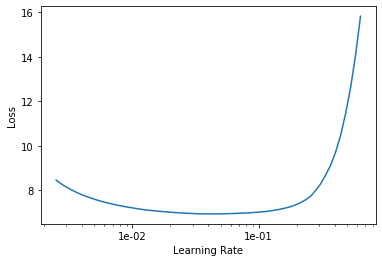

In [19]:
learn.recorder.plot()

In [20]:
lr = 1e-2
lr *= bs/48  # Scale learning rate by batch size

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(10, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,3.515756,3.482784,0.348293,3:33:54
1,3.657016,3.699899,0.326687,3:34:47
2,3.725499,3.756500,0.322936,3:33:39
3,3.733437,3.725423,0.325902,3:34:14
4,nan,nan,0.034470,3:28:57
5,nan,nan,0.034470,3:24:57


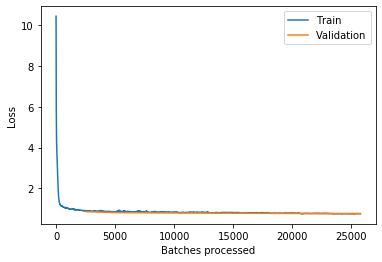

In [21]:
learn.recorder.plot_losses()

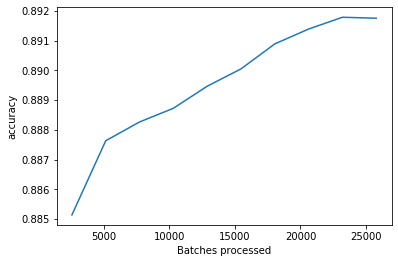

In [22]:
learn.recorder.plot_metrics()

Save the pretrained model and vocab:

In [23]:
mdl_path = path/'models'
mdl_path.mkdir(exist_ok=True)
learn.to_fp32().save(mdl_path/lm_fns[0], with_opt=False)
learn.data.vocab.save(mdl_path/(lm_fns[1] + '.pkl'))

## Spanish sentiment analysis

### Language model

- [Data](https://github.com/ngxbac/aivivn_phanloaisacthaibinhluan/tree/master/data)
- [Competition details](https://www.aivivn.com/contests/1)
- Top 3 f1 scores: 0.900, 0.897, 0.897

In [25]:
train_df = pd.read_csv(path/'train.csv')
train_df.loc[pd.isna(train_df.comment),'comment']='NA'
train_df.head()

,id,comment,label
0,train_000000,Dung dc sp tot cam on \nshop Đóng gói sản phẩm...,0
1,train_000001,Chất lượng sản phẩm tuyệt vời . Son mịn nhưng...,0
2,train_000002,Chất lượng sản phẩm tuyệt vời nhưng k có hộp ...,0
3,train_000003,:(( Mình hơi thất vọng 1 chút vì mình đã kỳ vọ...,1
4,train_000004,Lần trước mình mua áo gió màu hồng rất ok mà đ...,1


In [26]:
test_df = pd.read_csv(path/'test.csv')
test_df.loc[pd.isna(test_df.comment),'comment']='NA'
test_df.head()

,id,comment
0,test_000000,Chưa dùng thử nên chưa biết
1,test_000001,Không đáng tiềnVì ngay đợt sale nên mới mua n...
2,test_000002,Cám ơn shop. Đóng gói sản phẩm rất đẹp và chắc...
3,test_000003,Vải đẹp.phom oki luôn.quá ưng
4,test_000004,Chuẩn hàng đóng gói đẹp


In [27]:
df = pd.concat([train_df,test_df], sort=False)

In [28]:
data_lm = (TextList.from_df(df, path, cols='comment')
    .split_by_rand_pct(0.1, seed=42)
    .label_for_lm()           
    .databunch(bs=bs, num_workers=1))

In [29]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=1.0)

In [30]:
lr = 1e-3
lr *= bs/48

In [31]:
learn_lm.fit_one_cycle(2, lr*10, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.692393,4.099380,0.320605,00:09
1,4.244964,3.999981,0.328920,00:08


In [32]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,4.086195,3.894043,0.339551,00:11
1,3.948070,3.758920,0.352860,00:12
2,3.782116,3.661793,0.362277,00:12
3,3.692798,3.603717,0.368150,00:12
4,3.618032,3.566891,0.371568,00:12
5,3.564278,3.546957,0.373647,00:12
6,3.527288,3.538931,0.374498,00:12
7,3.515497,3.537494,0.374595,00:12


In [33]:
learn_lm.save(f'{lang}fine_tuned')
learn_lm.save_encoder(f'{lang}fine_tuned_enc')

### Classifier

In [34]:
data_clas = (TextList.from_df(train_df, path, vocab=data_lm.vocab, cols='comment')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=1))

data_clas.save(f'{lang}_textlist_class')

In [35]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)

In [9]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, np.argmax(inp, axis=-1))

In [38]:
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load_encoder(f'{lang}fine_tuned_enc')
learn_c.freeze()

In [46]:
learn.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(60000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(60000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=60000, bias=True)
    (output_dp): RNNDropout()
  )
)

In [39]:
lr=2e-2
lr *= bs/48

In [40]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.353253,0.279571,0.881841,0.844807,00:03
1,0.320652,0.257316,0.893657,0.863170,00:03


/home/dpalominop/anaconda3/envs/fastai/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [41]:
learn_c.fit_one_cycle(2, lr, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.336328,0.282114,0.880597,0.843231,00:03
1,0.296064,0.253697,0.891791,0.865806,00:03


In [42]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, slice(lr/(2.6**4),lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.302653,0.262736,0.880597,0.854715,00:04
1,0.258073,0.234263,0.900497,0.877101,00:04


In [43]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(2, slice(lr/2/(2.6**4),lr/2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.269781,0.244688,0.898632,0.869625,00:06
1,0.192816,0.238540,0.902985,0.877008,00:06


In [44]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, slice(lr/10/(2.6**4),lr/10), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,f1,time
0,0.171647,0.252014,0.898632,0.873800,00:08


In [45]:
learn_c.save(f'{lang}clas')

Competition top 3 f1 scores: 0.90, 0.89, 0.89. Winner used an ensemble of 4 models: TextCNN, VDCNN, HARNN, and SARNN.

## Ensemble

In [10]:
data_clas = load_data(path, f'{lang}_textlist_class', bs=bs, num_workers=1)
learn_c = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c.load(f'{lang}clas', purge=False);

In [11]:
preds,targs = learn_c.get_preds(ordered=True)
accuracy(preds,targs),f1(preds,targs)

(tensor(0.8986), tensor(0.8797))

In [14]:
data_clas_bwd = load_data(path, f'{lang}_textlist_class_bwd', bs=bs, num_workers=1, backwards=True)
learn_c_bwd = text_classifier_learner(data_clas_bwd, AWD_LSTM, drop_mult=0.5, metrics=[accuracy,f1]).to_fp16()
learn_c_bwd.load(f'{lang}clas_bwd', purge=False);

In [15]:
preds_b,targs_b = learn_c_bwd.get_preds(ordered=True)
accuracy(preds_b,targs_b),f1(preds_b,targs_b)

(tensor(0.9061), tensor(0.8894))

In [18]:
preds_avg = (preds+preds_b)/2

In [22]:
preds_avg = 0.5*preds+0.5*preds_b

In [23]:
accuracy(preds_avg,targs_b),f1(preds_avg,targs_b)

(tensor(0.9073), tensor(0.8908))